In [1]:
import requests
import time
from datetime import timedelta
import pickle
from gensim.models import doc2vec
import numpy as np
import time 

import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import DBSCAN, AffinityPropagation

from crashsimilarity import other_distances as od
from crashsimilarity.downloader import SocorroDownloader
from crashsimilarity import utils
from crashsimilarity.distance import DistanceCalculator

In [2]:
signature2 = 'OOM | large | js::AutoEnterOOMUnsafeRegion::crash | js::AutoEnterOOMUnsafeRegion::crash | js::TenuringTracer::moveToTenured'

In [3]:
def download_stack_traces(sigs, traces_num=1):
    from_date = utils.utc_today() - timedelta(days=360)
    if isinstance(sigs, str):
        sigs = [sigs]
    params = {'signature': ['^'+i for i in sigs],
              'date': ['>=' + str(from_date)],
              '_facets': ['proto_signature'],
              '_facets_size': traces_num
             }
    _SUPER_SEARCH_URL = 'https://crash-stats.mozilla.com/api/SuperSearch'
    r = requests.get(_SUPER_SEARCH_URL, params)
    return r.json()['facets']['proto_signature']

In [5]:
traces2 = download_stack_traces(signature2, traces_num=1000)

In [6]:
traces2 = set([i['term'] for i in traces2])
corpus = []
for x in traces2:
    words = utils.StackTraceProcessor.preprocess(x)
    if words[0] == '@0x':
        words = words[1:]
    corpus.append(words)
len(corpus)

1000

In [7]:
corpus = corpus[:500]
len(corpus)

500

In [7]:
class Tmp(object):
    def __init__(self, words):
        self.words = words
def struct_dist_calc(s1, s2):
    return od.edit_distance2(s1, s2, subst_cost=od.struct_word_dist)

In [8]:
struct_dist = od.edit_distance_matrix([Tmp(i) for i in corpus], struct_dist_calc)

10.0%, 15.58119511604309 s.
20.0%, 27.358853578567505 s.
30.0%, 39.787163972854614 s.
40.0%, 56.147698640823364 s.
50.0%, 73.63944339752197 s.
60.0%, 89.69224381446838 s.
70.0%, 105.37528133392334 s.
80.0%, 118.77197623252869 s.
90.0%, 133.4977149963379 s.


In [12]:
def dbscan(dist, eps=0.5, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(dist)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return labels, n_clusters, core_samples_mask

In [81]:
labels, n_clusters, core = dbscan(struct_dist, eps=3, min_samples=2)
n_clusters

45

In [14]:
def labels_to_clusters(labels):
    clusters = defaultdict(list)
    for i, c in enumerate(labels):
        if c != -1:
            clusters[c].append(i)
    return clusters

def dist_for_cluster(cluster, dist):
    rv = np.zeros((len(cluster), len(cluster)), dtype=np.double)
    for i, c in enumerate(cluster):
        for j, v in enumerate(cluster):
            rv[i, j] = dist[c, v]
    return rv

In [84]:
clusters = labels_to_clusters(labels)

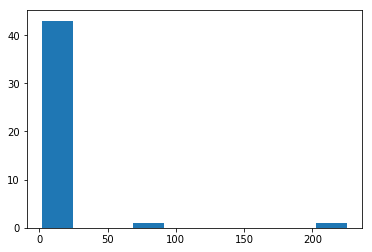

In [83]:
plt.hist([len(i) for i in clusters.values()])
plt.show()

In [91]:
big = clusters[1]
dist_big = np.zeros((len(big), len(big)), dtype=np.double)
for i, c in enumerate(big):
    for j, v in enumerate(big):
        dist_big[i, j] = struct_dist[c, v]
labels_small, n_clusters_small, core_small = dbscan(dist_big, eps=6, min_samples=2)
n_clusters_small

1

In [ ]:
sub = dbscan(stru)

In [19]:
dists = [dist_for_cluster(c,struct_dist) for c in clusters.values() ]

In [41]:
maxes = [np.max(i) for i in dists]

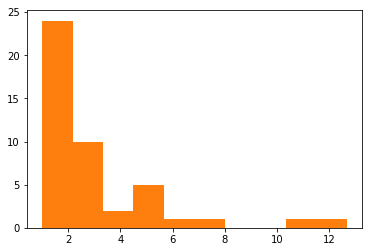

In [43]:
plt.hist(maxes)
plt.show()

In [65]:
def ap(dist):
    ap = AffinityPropagation(affinity='precomputed', damping=0.51)
    ap.fit(dist)
    labels = ap.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return labels, n_clusters

In [67]:
ap_labels, ap_n_clusters = ap(struct_dist)

In [68]:
ap_n_clusters

5